Wikidata and Bandford low analysis


https://linkedwiki.com/query/wikidata_Country_populations_together_with_total_city_populations?lang=EN

and Benford law :
https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8


## Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import math


import sys
import math
import matplotlib.pyplot as plt
%matplotlib inline


## Data aquisition

In [2]:


from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLWrapper import SPARQLWrapper2

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

strSparqlSelect = ("""
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT ?country ?countryLabel ?continentLabel ?population ?hdindex ?totalCityPopulation (?population / ?totalCityPopulation AS ?ratio) {
  ?country wdt:P1082 ?population .
  ?country wdt:P30  ?continent .
  ?continent wdt:P31 wd:Q5107 .
  ?country   wdt:P1081 ?hdindex
  
   FILTER NOT EXISTS {
    ?country wd:P1082/wdt:P585 ?hdi_date_ .
    FILTER (?hdi_date_ > ?hdi_date)
                     }
   FILTER NOT EXISTS {
    ?country wdt:P1081/wdt:P585 ?hdi_date_ .
    FILTER (?hdi_date_ > ?hdi_date)
                      }
 
  
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  {
    SELECT ?country (SUM(?cityPopulation) AS ?totalCityPopulation) WHERE {
      ?city wdt:P31 wd:Q515 .
      ?city wdt:P17 ?country .
      ?city wdt:P1082 ?cityPopulation .
      
    } GROUP BY ?country
  }
} ORDER BY ?ratio""")

sparql.setQuery(strSparqlSelect)
try:

  sparql.setReturnFormat(JSON)
  results = sparql.query().convert()
  # results = sparql.queryAndConvert()
  """
  # for testing
  for result in results["results"]["bindings"]:
      print(result)
  """

except Exception as e:
  print(e)

In [6]:

results["results"]["bindings"][0]

{'country': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q977'},
 'hdindex': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '0.509'},
 'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '956985'},
 'totalCityPopulation': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '2863922'},
 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Djibouti'},
 'continentLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Africa'},
 'ratio': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '0.33415190776843782757'}}

In [7]:
try:
    rawdata = [{"country" : x["countryLabel"]["value"],"continent" : x["continentLabel"]["value"],"totalCityPopulation" : round(float(x["totalCityPopulation"]["value"])), "population" : int(x["population"]["value"]), "ratio" : round(float(x["ratio"]["value"]),1)} for x in results["results"]["bindings"]]

except Exception as e:
  print(e)

rawdata[0]

{'country': 'Djibouti',
 'continent': 'Africa',
 'totalCityPopulation': 2863922,
 'population': 956985,
 'ratio': 0.3}

## A look at the data

In [8]:
maindata = pd.DataFrame(rawdata)
maindata.head()

,country,continent,totalCityPopulation,population,ratio
0,Djibouti,Africa,2863922,956985,0.3
1,São Tomé and Príncipe,Africa,391964,204327,0.5
2,New Zealand,Insular Oceania,7145560,5118700,0.7
3,United Arab Emirates,Asia,12009189,9890400,0.8
4,North Macedonia,Europe,2051544,1836713,0.9


In [9]:
# Provide the number of rows and columns in this dataset.
num_rows = maindata.shape[0] #Provide the number of rows in the dataset
num_cols = maindata.shape[1] #Provide the number of columns in the dataset
(num_rows,num_cols)

(198, 5)

In [10]:
# A set of column names that have no missing values.
no_nulls = set(maindata.columns[maindata.isnull().mean()==0])#Provide a set of columns with 0 missing values.
no_nulls

{'continent', 'country', 'population', 'ratio', 'totalCityPopulation'}

In [41]:
maindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              198 non-null    object 
 1   continent            198 non-null    object 
 2   totalCityPopulation  198 non-null    int64  
 3   population           198 non-null    int64  
 4   ratio                198 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.9+ KB


### Analyse uniqunes of country data

In [35]:
maindata.nunique(axis=0)

country                187
continent                6
totalCityPopulation    187
population             188
ratio                  107
dtype: int64

In [40]:
# identification of duplicates among countries
maindata[maindata.duplicated(keep=False, subset=['country'])]

,country,continent,totalCityPopulation,population,ratio
25,Georgia,Europe,2196070,3717100,1.7
26,Georgia,Asia,2196070,3717100,1.7
32,Kazakhstan,Europe,9800394,18276500,1.9
33,Kazakhstan,Asia,9800394,18276500,1.9
39,Turkey,Europe,40725414,84680273,2.1
40,Turkey,Asia,40725414,84680273,2.1
59,Panama,South America,1479264,4098587,2.8
60,Panama,North America,1479264,4098587,2.8
64,Egypt,Africa,33411500,94798827,2.8
65,Egypt,Asia,33411500,94798827,2.8


Artificial duplicities are mainly due to country population overlaping over several continents. The amount of population is same for different continents, so we can take this value only once.

In [11]:
maindata.drop_duplicates(subset=['country'])

In [12]:
maindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              198 non-null    object 
 1   continent            198 non-null    object 
 2   totalCityPopulation  198 non-null    int64  
 3   population           198 non-null    int64  
 4   ratio                198 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.9+ KB


## A business look at the data quality and objective feasibility

Text(0.5, 1.0, 'Comparing population of the state with agregated city population ')

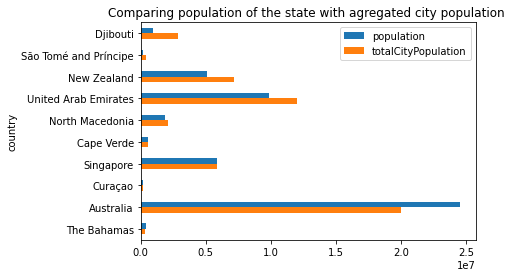

In [23]:
# pd.DataFrame(rawdata).set_index("country").head(10).plot.barh().invert_yaxis()
maindata[["country","population","totalCityPopulation"]].set_index("country").head(10).plot.barh().invert_yaxis()
plt.title("Comparing population of the state with agregated city population ")

In [29]:
# Let we analyse data quality, where agreation of city population exceeds totoal country population. This id due to the fact probablz, that 
# we have counted city citizens at Wikidata over overlaping cities - regions
maindata[maindata["ratio"]<1]

,country,continent,totalCityPopulation,population,ratio
0,Djibouti,Africa,2863922,956985,0.3
1,São Tomé and Príncipe,Africa,391964,204327,0.5
2,New Zealand,Insular Oceania,7145560,5118700,0.7
3,United Arab Emirates,Asia,12009189,9890400,0.8
4,North Macedonia,Europe,2051544,1836713,0.9


In [30]:
# If ratio eexceeds 10 we can face situation of very rural country or very low coverage of city poůpulation by Wikidata
maindata[maindata["ratio"]>100]

,country,continent,totalCityPopulation,population,ratio
191,Ukraine,Europe,365839,41588354,113.7
192,Portugal,Europe,83401,10347892,124.1
193,Palestinian territories,Asia,19197,4550000,237.0
194,Indonesia,Asia,841902,275439000,327.2
195,Indonesia,Insular Oceania,841902,275439000,327.2
196,Iran,Asia,54178,86758304,1601.4
197,Philippines,Asia,61432,109035343,1774.9


## Bendford law processing
using functions from https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8


In [7]:
# according to 

def count_first_digit(data_str):
    mask=df[data_str]>1.
    data=list(df[mask][data_str])
    for i in range(len(data)):
        while data[i]>10:
            data[i]=data[i]/10
    first_digits=[int(x) for x in sorted(data)]
    unique=(set(first_digits))#a list with unique values of     first_digit list
    data_count=[]
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    total_count=sum(data_count)
    data_percentage=[(i/total_count)*100 for i in data_count]
    return  total_count,data_count, data_percentage
# Benford's Law percentages for leading digits 1-9
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

In [1]:
# code from https://github.com/eleprocha/Benford-s-Law_python_code/blob/master/code
# https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test
#import libraries
import numpy as np
import pandas as pd
import sys
import math
from collections import defaultdict
import matplotlib.pyplot as plt

#Load data from an excel file and set as variable the numeric column which it is about  to make the goodnsess of fit test
def load_data(filename,var):
        df=pd.read_excel(filename)
        data=df[var]
        return df,data
        
#Data exploratory       
data.describe()
df.info()
df.describe().transpose
df.isnull().sum()

#we create a function which output is the final counts, and the frequency of each count as a
#percentage, are returned as lists to use in subsequent functions.
def count_first_digit(data_str):#TAKE AS AN ARGUMENT A STR-COLUMN NAME
    mask=df[data_str]>1.
    data=list(df[mask][data_str])
    for i in range(len(data)):
        while data[i]>10:
            data[i]=data[i]/10
    first_digits=[int(x) for x in sorted(data)]
    unique=(set(first_digits))#a list with unique values of first_digit list
    data_count=[]
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    total_count=sum(data_count)
    data_percentage=[(i/total_count)*100 for i in data_count]
    return  total_count,data_count, data_percentage
    
    # Benford's Law percentages for leading digits 1-9
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

def get_expected_counts(total_count):

    """Return list of expected Benford's Law counts for total sample count."""

    return [round(p * total_count / 100) for p in BENFORD]
expected_counts=get_expected_counts(total_count)

def chi_square_test(data_count,expected_counts):

    """Return boolean on chi-square test (8 degrees of freedom & P-val=0.05)."""

    chi_square_stat = 0  # chi square test statistic

    for data, expected in zip(data_count,expected_counts):

        chi_square = math.pow(data - expected, 2)

        chi_square_stat += chi_square / expected

    print("\nChi-squared Test Statistic = {:.3f}".format(chi_square_stat))

    print("Critical value at a P-value of 0.05 is 15.51.")    

    return chi_square_stat < 15.51
chi_square_test(data_count,expected_counts)

#1st_bar_chart
def bar_chart(data_pct):

    """Make bar chart of observed vs expected 1st digit frequency in percent."""

    fig, ax = plt.subplots()



    index = [i + 1 for i in range(len(data_pct))]  # 1st digits for x-axis
# text for labels, title and ticks

    fig.canvas.set_window_title('Percentage First Digits')

    ax.set_title('Data vs. Benford Values', fontsize=15)

    ax.set_ylabel('Frequency (%)', fontsize=16)

    ax.set_xticks(index)

    ax.set_xticklabels(index, fontsize=14)



    # build bars    

    rects = ax.bar(index, data_pct, width=0.95, color='black', label='Data')



    # attach a text label above each bar displaying its height

    for rect in rects:

        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2, height,

                '{:0.1f}'.format(height), ha='center', va='bottom', 

                fontsize=13)



    # plot Benford values as red dots

    ax.scatter(index, BENFORD, s=150, c='red', zorder=2, label='Benford')



    # Hide the right and top spines & add legend

    ax.spines['right'].set_visible(False)

    ax.spines['top'].set_visible(False)

    ax.legend(prop={'size':15}, frameon=False)

    

    plt.show()
    
    #2nd_bar_chart
    labels=list(data_percentage)
width = 0.35 
x = np.arange(len(data_percentage)) # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, data_percentage, width=0.95, color='black', label='Data')
rects2 = ax.bar(x + width, BENFORD,width,label='Benford')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=16)
ax.set_title('Benford')
ax.set_xticks(x)
ax.legend()
plt.show()





NameError: name 'data' is not defined

In [ ]:
#specify the main() function and runs the program & prints some statistics.
def main(data_list):
    total_count,data_count, data_percentage= count_first_digit(data_list)

    expected_counts = get_expected_counts(total_count)

    print("\nobserved counts = {}".format(data_count))

    print("expected counts = {}".format(expected_counts), "\n")


    print("First Digit Probabilities:")

    for i in range(1, 10):

        print("{}: observed: {:.3f}  expected: {:.3f}".

              format(i, data_percentage[i - 1] / 100, BENFORD[i - 1] / 100))



    if chi_square_test(data_count, expected_counts):

        print("Observed distribution matches expected distribution.")

    else:

        print("Observed distribution does not match expected.", file=sys.stderr)       



    bar_chart(data_percentage)


